In [1]:
import scipy.linalg
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from time import time as tm

import torch 
from models import RateModel
from utils import ToNP, MakeSmoothGaussianProcess, TorchPCA, GetOrthonormalVectors

# Save figures?
SaveFigs=True

device='cpu'
print('Device =',device)

# seed rng
torch.manual_seed(0)



####### Set parameter values

# Number of neurons in recurrent net
N = 200

# Parameters for connectivity matrix
c=-10
rho=0.5

# Direction, u, of low rank part
u = torch.randn(N).to(device)
u *= 1/u.norm()
v = u

# Duration of sim
T=5000

# Time step size, timescale of dynamics
dt = 0.01
tau = 1


###########
# Random part of W
W1 = rho*torch.randn(N,N)/np.sqrt(N)

# Timescale and strength of Guassian random stimulus
taux=5
sigmax=1


W0 = c*torch.outer(u,v)
W = W0+W1


############

# Random direction
urand = torch.randn(N).to(device)
urand *= 1/urand.norm()

# Coefficient for RNN Euler integrator
eta = dt/tau

# Model and random model
model = RateModel(W, f='id', eta = eta, bias_recurrent=False, Network_Type='Z').to(device)


# Timescale and strength of Guassian random stimulus
taux=10
sigmax=2

# Discretized time for second sim
time=np.arange(0,T,dt)
Nt=len(time)


# Generate input and run sim
with torch.no_grad():
    t0=tm()
    x = sigmax*MakeSmoothGaussianProcess(taux,Nt,dt,N,device=device).T
    x = x[None,:,:].float().to(device)
    tx = tm()-t0
    print('Time to generate x(t):',tx,'s')
    t0=tm()
    r = model(x, return_time_series = True, store_hidden_history = True, initial_state=.1*torch.randn(N).to(device) )
    z = model.hidden_state_history

    tsim = tm()-t0
    print('Time for  sim:',tsim,'s')

    # Perform PCA on x and z
    t0=tm()
    Ux,Sx=TorchPCA(x[0,:,:], scaled=False)
    Uz,Sz=TorchPCA(z[0,:,:], scaled=False)
    Cx=torch.cov(x[0,:,:].T)
    sqrtCx=scipy.linalg.sqrtm(Cx)
    print('Time for PCA calc:',tm()-t0)
    
    # Theoretical result using theoretical Cx
    ###SzTh1 = np.linalg.svdvals(np.linalg.inv(np.eye(N)-ToNP(W))*sigmax)**2
    SzTh1 = sigmax**2/np.linalg.svdvals(np.eye(N)-ToNP(W))**2
    SzTh1 = SzTh1[::-1]
    
    # Theoretical result using sample Cx
    SzTh2 = np.linalg.svdvals(np.linalg.inv(np.eye(N)-ToNP(W))@sqrtCx)**2


Device = cpu
Time to generate x(t): 1.4795970916748047 s
Time for  sim: 12.316307306289673 s
Time for PCA calc: 3.0688910484313965


Time to generate x(t): 20.086461067199707 s
Time for  sim: 123.3518750667572 s
Time for PCA calc: 29.745845079421997
done


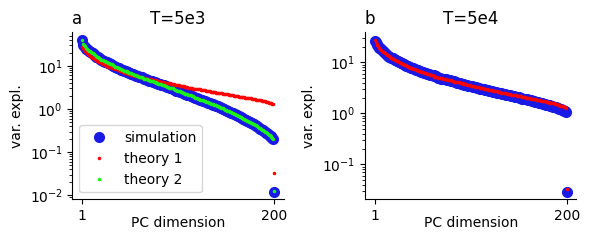

In [2]:

### Make Figure 
xclr = [.1,.6,.1]
yclr = [.7,.2,.7]
zclr = [.1,.1,.9]
Wclr = [.8,.1,.1]

numplot = N


fig, axes = plt.subplot_mosaic("ab",figsize=(6,2.5))



c0='a'
ax0 = axes[c0]
ax0.plot(np.arange(N)+1,Sz,'o',label='simulation',markersize=7,color=zclr)
ax0.plot(np.arange(N)+1,SzTh1,'.',label='theory 1',markersize=3,color='r')
ax0.plot(np.arange(N)+1,SzTh2,'.',label='theory 2',markersize=3,color=[.1,.95,.1])
ax0.set_xscale('linear')
ax0.set_yscale('log')
ax0.set_xlabel('PC dimension',labelpad=-5)
ax0.set_xticks([1,N])
ax0.set_title('T=5e3')
#ax0.set_ylim(bottom=(100*Sz/Sz.sum()).min()*.5)
ax0.set_ylabel('var. expl.')
ax0.legend(loc='best')#(.98,.05))
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)


# Duration of sim
T=50000


# Discretized time for second sim
time=np.arange(0,T,dt)
Nt=len(time)


# Generate input and run sim
with torch.no_grad():
    t0=tm()
    x = sigmax*MakeSmoothGaussianProcess(taux,Nt,dt,N,device=device).T
    x = x[None,:,:].float().to(device)
    tx = tm()-t0
    print('Time to generate x(t):',tx,'s')
    t0=tm()
    r = model(x, return_time_series = True, store_hidden_history = True, initial_state=.1*torch.randn(N).to(device) )
    z = model.hidden_state_history

    tsim = tm()-t0
    print('Time for  sim:',tsim,'s')

    # Perform PCA on x and z
    t0=tm()
    Ux,Sx=TorchPCA(x[0,:,:], scaled=False)
    Uz,Sz=TorchPCA(z[0,:,:], scaled=False)
    Cx=torch.cov(x[0,:,:].T)
    sqrtCx=scipy.linalg.sqrtm(Cx)
    print('Time for PCA calc:',tm()-t0)
    
    # Theoretical result using theoretical Cx
    ###SzTh1 = np.linalg.svdvals(np.linalg.inv(np.eye(N)-ToNP(W))*sigmax)**2
    SzTh1 = sigmax**2/np.linalg.svdvals(np.eye(N)-ToNP(W))**2
    SzTh1 = SzTh1[::-1]
    
    # Theoretical result using sample Cx
    SzTh2 = np.linalg.svdvals(np.linalg.inv(np.eye(N)-ToNP(W))@sqrtCx)**2


c0='b'
ax0 = axes[c0]
ax0.plot(np.arange(N)+1,Sz,'o',label='simulation',markersize=7,color=zclr)
ax0.plot(np.arange(N)+1,SzTh1,'.',label='theory 1',markersize=3,color='r')
ax0.set_xscale('linear')
ax0.set_yscale('log')
ax0.set_xlabel('PC dimension',labelpad=-5)
ax0.set_xticks([1,N])
ax0.set_title('T=5e4')
#ax0.set_ylim(bottom=(100*Sz/Sz.sum()).min()*.5)
ax0.set_ylabel('var. expl.')
#ax0.legend(loc='best')#(.98,.05))
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)


fig.tight_layout()



if SaveFigs:
    fig.savefig('./Figures/SuppFigTheory.pdf')
    fig.savefig('./Figures/SuppFigTheoryunpolished.svg')

print('done')

